# Data analysis for the chapter "Consistency"

This notebook can be used to reproduce the data analysis of the Chapter "Consistency" of the technical report ["Assessing a Formal Model of Reflective Equilibrium"](https://re-models.github.io/re-technical-report/). 

## How to run this notebook

There are several possibilities to execute this notebook. You can, for instance,

1. execute this notebook on Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/re-models/re-technical-report/blob/main/notebooks/data_analysis_chapter_commitment-consistency.ipynb), or
2. execute this notebook locally in, for instance, [JupyterLab](https://jupyter.org/) by cloning the Github repository of the report (for details, see <https://github.com/re-models/re-technical-report>).

Note, however, that Colab is not suited to analyse the full data set that is used in the report. Instead, you can only use the subdata set `TINY` (see <https://github.com/re-models/re-technical-report> for details).

## Installing and importing libraries

In [1]:
!pip install re-technical-report

You should consider upgrading via the 'C:\Users\afrei\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [26]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots



from re_technical_report import (
    re_data_by_name,
    rel_share_of_property,
    plot_multiple_error_bars,
    heat_maps_by_weights,
    set_errorbar_plot_style,
    set_heatmap_plot_style,
)

In [5]:
# custom color palettes
viridis = ["#472c7a", 
           "#2c718e", 
           "#29ae80", 
           "#b0dd31"]

viridis_light = ["rgba(71, 44, 122, 0.5)", 
                 "rgba(44, 113, 142, 0.5)", 
                 "rgba(41, 174, 128, 0.5)", 
                 "rgba(176, 221, 49, 0.5)"]

coolwarm = ['#6788ee', 
            '#9abbff', 
            '#e26952', 
            '#f7a889']

## Loading data

In [6]:
# Directories that are use to save generated tables and figures.
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

# Are we on Colab?
on_colab = 'google.colab' in str(get_ipython())

# Configuring sns styles
set_errorbar_plot_style()
set_heatmap_plot_style()

In [24]:
# TODO: remove
on_colab = True

In [10]:
# Columns relevant for this notebook.
usecols = ["model_name",
           "n_sentence_pool",
           "ds",
           "init_coms",
           "init_coms_dia_consistent",
           "weight_account", 
           "weight_systematicity",
           "go_coms_consistent",
           "fp_coms_consistent",
           "fixed_point_coms_consistent",
           "fixed_point_dia_consistent",
           "n_fixed_points",
           "n_global_optima",
           "go_union_consistent",
           "fp_union_consistent",
           "error_code"]

In [11]:
# Columns that need to be evaluated literally 
evalcols =["go_coms_consistent",
           "fp_coms_consistent",
           "go_union_consistent",
           "fp_union_consistent"]

In [12]:
# data_name: one of 'TINY', 'MINI', 'FULL'
re_data = re_data_by_name(data_name="TINY", 
                          usecols = usecols,
                          evalcols = evalcols,
                          filter_erroneous_runs = True)

In [13]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 12637
   Number of dialectical structures: 2
   Overall number of initial commitments: 40
   Sentence-pools: [6 7]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [16]:
# counting simulation setups
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                                                 "ds",
                                                 "n_sentence_pool",
                                                 "weight_account", 
                                                 "weight_systematicity", 
                                                 "init_coms"
                                                ])

re_data_unique_setups.groupby(['model_name']).size()

model_name
LinearGlobalRE       1440
LinearLocalRE        1440
QuadraticGlobalRE    1440
QuadraticLocalRE     1440
dtype: int64

## Setup dataframes

If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point if they are reached on different paths from a simulation setup. The corresponing results are presented under rubric of *process perspective* in the technical report. Otherwise, the subsequent analysis comprises only unique fixed points per simulation setup resulting in what is called *result perspectve* in the technical report.

In [17]:
analyse_branches = False

`bootstrap` determines whether bootstrapping is applied to estimate the mean and the standard deviation. `n_resamples` sets the number of resamples use for bootstrapping.

In [18]:
bootstrap = True
n_resamples = 400

### Dataframe for global optima

In [20]:
# restrict unique simulation setups to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "n_sentence_pool",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity", 
                                 "init_coms_dia_consistent", 
                                 "go_coms_consistent",
                                 "go_union_consistent"]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_coms_consistent`) 
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "n_sentence_pool",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity", 
                                      "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(16476, 9)

In [22]:
# We restrict some graphics to two models variants for global optima 
# graphics in order to avoid (almost) redundant results.

go_models = ["LinearGlobalRE", "QuadraticGlobalRE"]

### Dataframe for fixed points

In [23]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "n_sentence_pool",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       "init_coms_dia_consistent", 
                       "fixed_point_coms_consistent",
                       "fixed_point_dia_consistent"]]
    
    # rename fixed point columns 
    # note: data is already exploded
    exploded_fp_data = fp_data.rename(columns={"fixed_point_coms_consistent": "fp_coms_consistent",
                                               "fixed_point_dia_consistent": "fp_union_consistent"})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "n_sentence_pool",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "init_coms_dia_consistent", 
                                     "fp_coms_consistent",
                                     "fp_union_consistent"]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `go_coms_consistent`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "n_sentence_pool",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity", 
                                          "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(9392, 9)

## Consistency I: Output
Are the commitments of RE simulation outputs dialectically consistent?

### Overall Results grouped by model variant

In [27]:
# create separate tables for global optimaa and fixed points

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = rel_share_of_property(df, 
                           "{}_coms_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name',
                                                   'ds',
                                                   'init_coms', 
                                                   'weight_account', 
                                                   'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'sum_go_coms_consistent': 'Number of global optima with consistent commitments',
                   'size_go_coms_consistent': 'Number of global optima',
                   'rel_go_coms_consistent': 'Relative share of global optima with consistent commitments',
                   'std_go_coms_consistent': 'Standard deviation', 
                   'sum_fp_coms_consistent': 'Number of fixed points with consistent commitments',
                   'size_fp_coms_consistent': 'Number of fixed points',
                   'rel_fp_coms_consistent': 'Relative share of fixed points with consistent commitments',
                   'std_fp_coms_consistent': 'Standard deviation',  
                  }

    display(result_df.rename(columns=cols_for_tables))
    
    
    if not on_colab:
        file_name = 'table_consistent_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Relative share of global optima with consistent commitments,Standard deviation,Number of global optima with consistent commitments,Number of global optima
2,QuadraticGlobalRE,0.615055,0.007415,2584,4200
0,LinearGlobalRE,0.665816,0.007118,2689,4038
3,QuadraticLocalRE,0.615055,0.007415,2584,4200
1,LinearLocalRE,0.665816,0.007118,2689,4038


,Model,Relative share of fixed points with consistent commitments,Standard deviation,Number of fixed points with consistent commitments,Number of fixed points
2,QuadraticGlobalRE,0.649047,0.009940,1679,2586
0,LinearGlobalRE,0.721166,0.009268,1722,2386
3,QuadraticLocalRE,0.588330,0.009490,1575,2677
1,LinearLocalRE,0.750143,0.010776,1307,1743


### Results grouped by sentence pool size

In [28]:
grouping = ['model_name',
            'n_sentence_pool',]

In [63]:
x = np.sort(exploded_go_data["n_sentence_pool"].unique())

x

array([6, 7, 8, 9])

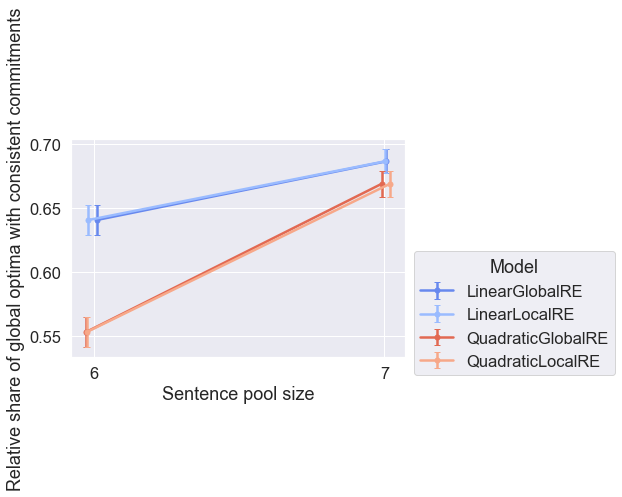

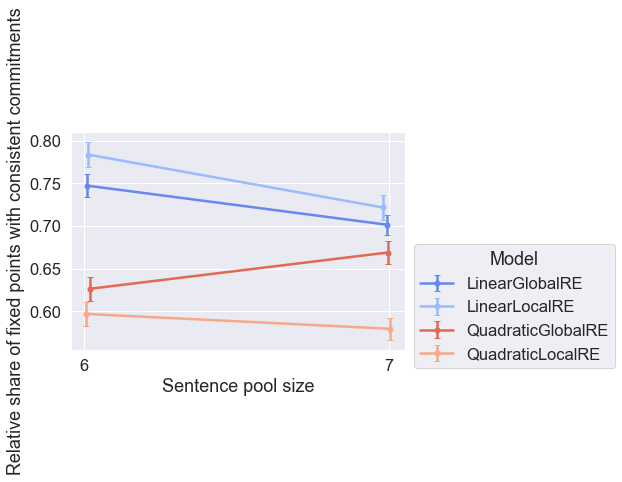

In [67]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = rel_share_of_property(df, 
                           "{}_coms_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    perspective = "pp" if analyse_branches else "rp"
    
    file_name = None
    
    if not on_colab:
        file_name = f"rel_consistent_{endpoint_type}_by_sp_{perspective}"
    
    xticks = np.sort(df["n_sentence_pool"].unique())
    
    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_coms_consistent", 
                             ylabel = f"Relative share of {endpoint} with consistent commitments",
                             xlabel = "Sentence pool size",
                             xticks = xticks,
                             var_std=f"std_{endpoint_type}_coms_consistent",
                             file_name=file_name,
                             output_dir = figures_output_dir)
    
    plt.show()

### Results grouped by weight configuration

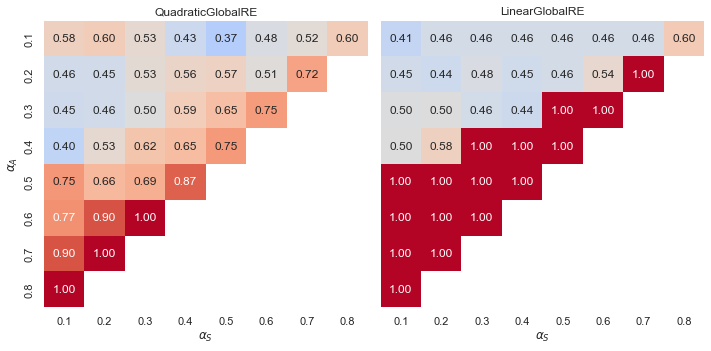

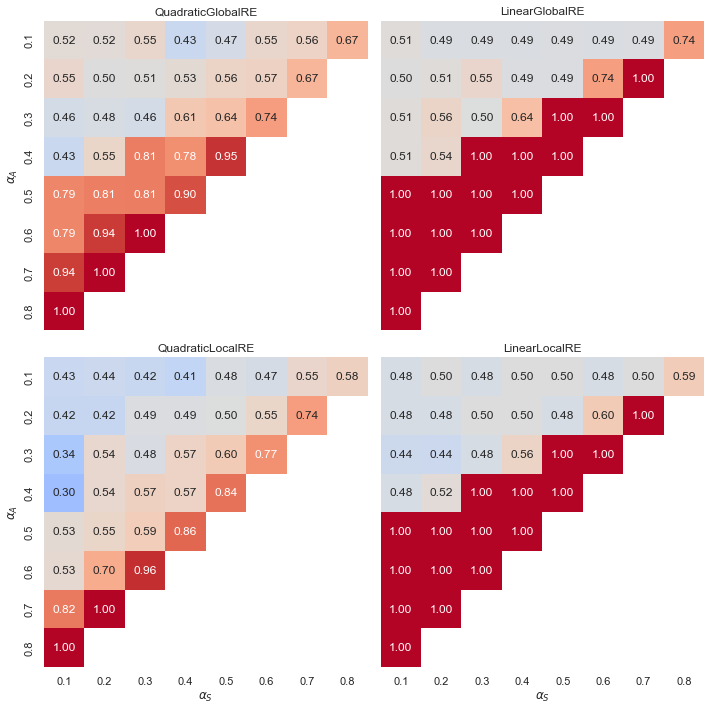

In [30]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):

    endpoint = "global opima" if endpoint_type == "go" else "fixed points"
    
    if (analyse_branches) & (endpoint_type=="fp"):
        endpoint += " (all branches)"
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        df = df[df["model_name"].isin(go_models)]
    
    heat_maps_by_weights(re_data = df, 
                     values = "{}_coms_consistent".format(endpoint_type), 
                     #title = 'Relative share of consistent commitments among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.2f}',
                     vmin=0, vmax=1.0,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    
    perspective = "pp" if analyse_branches else "rp"
        
    if not on_colab:
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_coms_{}_{}.png'.format(endpoint_type, perspective)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_coms_{}_{}.pdf'.format(endpoint_type, perspective)), bbox_inches='tight')
        
    plt.show()

## Consistency II:  Input-Output
Does the consistency status change between corresponding intial and output commitments of RE simulations?

### Labelling cases

In [31]:
# conversion to type bool
exploded_go_data['init_coms_dia_consistent'] = exploded_go_data['init_coms_dia_consistent'].astype('bool')
exploded_go_data['go_coms_consistent'] = exploded_go_data['go_coms_consistent'].astype('bool')

In [32]:
# global optima
exploded_go_data['go_inconsistency_eliminating_case'] = (~exploded_go_data['init_coms_dia_consistent']) & exploded_go_data['go_coms_consistent']
exploded_go_data['go_consistency_preserving_case'] = exploded_go_data['init_coms_dia_consistent'] & exploded_go_data['go_coms_consistent']
exploded_go_data['go_inconsistency_preserving_case'] = (~exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])
exploded_go_data['go_consistency_eliminating_case'] = (exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])

In [33]:
# conversion to boolean type
exploded_fp_data['init_coms_dia_consistent'] = exploded_fp_data['init_coms_dia_consistent'].astype('bool')
exploded_fp_data['fp_coms_consistent'] = exploded_fp_data['fp_coms_consistent'].astype('bool')

In [34]:
# fixed points
exploded_fp_data['fp_inconsistency_eliminating_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_consistency_preserving_case'] = exploded_fp_data['init_coms_dia_consistent'] & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_inconsistency_preserving_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & ~(exploded_fp_data['fp_coms_consistent'])
exploded_fp_data['fp_consistency_eliminating_case'] = exploded_fp_data['init_coms_dia_consistent'] & ~(exploded_fp_data['fp_coms_consistent'])

### Tables

In [35]:
# separate tables for go and fp

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = None
    
    for case_name in ["consistency_preserving",
                      "consistency_eliminating",
                      "inconsistency_preserving",
                      "inconsistency_eliminating", 
                      ]:
        
        
        if case_name in ["consistency_preserving", "consistency_eliminating"]:
            # consistent init coms
            rdf = df[df["init_coms_dia_consistent"]]
        else:
            rdf = df[~df["init_coms_dia_consistent"]]
        
        new_result_df = rel_share_of_property(rdf,
                            endpoint_type + "_" + case_name + "_case", 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
        
        new_result_df.reset_index(inplace=True)
        
        
        if result_df is None:
            result_df = new_result_df
        else:
            result_df = result_df.join(new_result_df.set_index("model_name"), on="model_name")
                
    # for later use
    if endpoint_type == "go":
        go_result_df = result_df
    else:
        fp_result_df = result_df
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   "size_go_inconsistency_eliminating_case": "Number of global optima from inconsistent initial commitments",
                   "size_fp_consistency_eliminating_case": "Number of fixed points from consistent initial commitments",
                   "size_go_consistency_eliminating_case": "Number of global optima from consistent initial commitments",
                   "size_fp_inconsistency_eliminating_case": "Number of fixed points from inconsistent initial commitments",
                   "rel_go_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases",
                   "rel_go_consistency_preserving_case": "Relative share of consistency preserving cases",
                   "rel_go_inconsistency_preserving_case": "Relative share of inconsistency preserving cases",
                   "rel_go_consistency_eliminating_case": "Relative share of consistency eliminating cases",
                   "rel_fp_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases",
                   "rel_fp_consistency_preserving_case": "Relative share of consistency preserving cases",
                   "rel_fp_inconsistency_preserving_case": "Relative share of inconsistency preserving cases",
                   "rel_fp_consistency_eliminating_case": "Relative share of consistency eliminating cases",
                   "std_go_inconsistency_eliminating_case": "Standard deviation IE cases",
                   "std_fp_inconsistency_eliminating_case": "Standard deviation IE cases",
                   "std_go_inconsistency_preserving_case": "Standard deviation IP cases",
                   "std_fp_inconsistency_preserving_case": "Standard deviation IP cases",
                   "std_go_consistency_preserving_case": "Standard deviation CP cases",
                   "std_fp_consistency_preserving_case": "Standard deviation CP cases",
                   "std_go_consistency_eliminating_case": "Standard deviation CE cases",
                   "std_fp_consistency_eliminating_case": "Standard deviation CE cases",
                  }
    renamed_result_df = result_df.rename(columns=cols_for_tables)
    
    # restrict to most relevant columns
    retain_columns = [col for col in renamed_result_df.columns if (("size" not in col) and ("sum" not in col))]
    
    renamed_result_df = renamed_result_df[retain_columns]
    
    # reorder columns (number of endpoints should go to front)
    ordered_cols = []

    ordered_cols.append(renamed_result_df.columns[0])
    ordered_cols.append(renamed_result_df.columns[3])
    ordered_cols.append(renamed_result_df.columns[1])
    ordered_cols.append(renamed_result_df.columns[2])
    for col in renamed_result_df.columns[4:]:
        ordered_cols.append(col)

    renamed_result_df = renamed_result_df[ordered_cols]

    display(renamed_result_df)
    
    
    # Exporting relevant cols
    if not on_colab:
        file_name = 'table_consistency_cases_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        renamed_result_df.to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Relative share of consistency eliminating cases,Relative share of consistency preserving cases,Standard deviation CP cases,Standard deviation CE cases,Number of global optima from consistent initial commitments,Relative share of inconsistency preserving cases,Standard deviation IP cases,Relative share of inconsistency eliminating cases,Standard deviation IE cases,Number of global optima from inconsistent initial commitments
2,QuadraticGlobalRE,0.075889,0.924111,0.006105,0.006105,1871,0.632867,0.010097,0.367133,0.010097,2329
0,LinearGlobalRE,0.059319,0.940681,0.005509,0.005509,1780,0.550209,0.010321,0.449791,0.010321,2258
3,QuadraticLocalRE,0.075889,0.924111,0.006105,0.006105,1871,0.632867,0.010097,0.367133,0.010097,2329
1,LinearLocalRE,0.059319,0.940681,0.005509,0.005509,1780,0.550209,0.010321,0.449791,0.010321,2258


,Model,Relative share of consistency eliminating cases,Relative share of consistency preserving cases,Standard deviation CP cases,Standard deviation CE cases,Number of fixed points from consistent initial commitments,Relative share of inconsistency preserving cases,Standard deviation IP cases,Relative share of inconsistency eliminating cases,Standard deviation IE cases,Number of fixed points from inconsistent initial commitments
2,QuadraticGlobalRE,0.042995,0.957005,0.005621,0.005621,1213,0.622296,0.012138,0.377704,0.012138,1373
0,LinearGlobalRE,0.043670,0.956330,0.005942,0.005942,1205,0.518497,0.013641,0.481503,0.013641,1181
3,QuadraticLocalRE,0.052962,0.947038,0.007289,0.007289,968,0.614598,0.012095,0.385402,0.012095,1709
1,LinearLocalRE,0.057931,0.942069,0.007745,0.007745,842,0.427564,0.016987,0.572436,0.016987,901


### Overall results grouped by model variant

In [40]:
def barplot(data, endpoint_type, init_coms_consistent):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdata = data[data["model_name"].isin(go_models)]
    else:
        rdata=data
    
    if init_coms_consistent:
        y_cols = ["rel_{}_consistency_preserving_case".format(endpoint_type),
                  "rel_{}_consistency_eliminating_case".format(endpoint_type)]
    else:
        y_cols = ["rel_{}_inconsistency_eliminating_case".format(endpoint_type),
                  "rel_{}_inconsistency_preserving_case".format(endpoint_type)]    
    
    fig3 = px.bar(rdata.round(3), 
                  x="model_name", 
                  y=y_cols,
                  barmode="stack", 
                  text_auto=True)

    fig3.update_yaxes(range=[0.0, 1.0])
    fig3.update_traces(name="Consistency preserving (CP)", 
                       marker_color=coolwarm[0], 
                       selector=dict(name='rel_{}_consistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency eliminating (IE)", 
                       marker_color=coolwarm[2],
                       selector=dict(name='rel_{}_inconsistency_eliminating_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency preserving (IP)",
                       marker_color=coolwarm[3],
                       selector=dict(name='rel_{}_inconsistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Consistency eliminating (CE)",
                       marker_color=coolwarm[1], 
                       selector=dict(name="rel_{}_consistency_eliminating_case".format(endpoint_type)))

    fig3.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       width=860 if endpoint_type=="fp" else 580,
                       margin={"t":80}
                      )

    fig3.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig3.update_yaxes(title="Relative share", ticks="outside", tickcolor="DarkGrey", showgrid=False, linecolor='DarkGrey', zeroline=True, zerolinecolor="DarkGrey",
                      zerolinewidth=1)
    fig3.update_layout(legend_title_text="")
    fig3.update_layout(legend={'traceorder':'reversed', 
                              "orientation":"v", "x":1.0, "y":1.025, "xanchor":"left"})
    #fig3.update_layout(title_text="Relative share of consistency cases among {}".format("global optima" if endpoint_type=="go" else "fixed points"))
    fig3.update_traces(opacity=0.8)
    fig3.show()



    if not on_colab:
        file_name = 'consistency_cases_{}_{}_{}.png'.format(endpoint_type,
                                                                 "ic_cons" if init_coms_consistent else "ic_incons",
                                                                 'pp' if analyse_branches else 'rp')
        fig3.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'consistency_cases_{}_{}_{}.pdf'.format(endpoint_type,
                                                                 "ic_cons" if init_coms_consistent else "ic_incons",
                                                                 'pp' if analyse_branches else 'rp')
        fig3.write_image(path.join(figures_output_dir, file_name), scale=2)

In [41]:
barplot(go_result_df, "go", True)
barplot(fp_result_df, "fp", True)
barplot(go_result_df, "go", False)
barplot(fp_result_df, "fp", False)

### Result grouped by sentence pool size

In [42]:
grouping = ['model_name', "n_sentence_pool"]

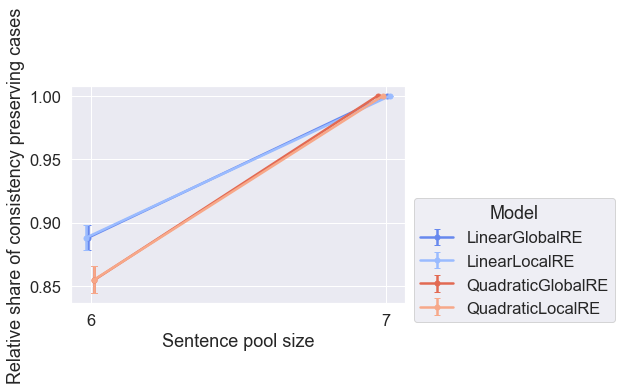

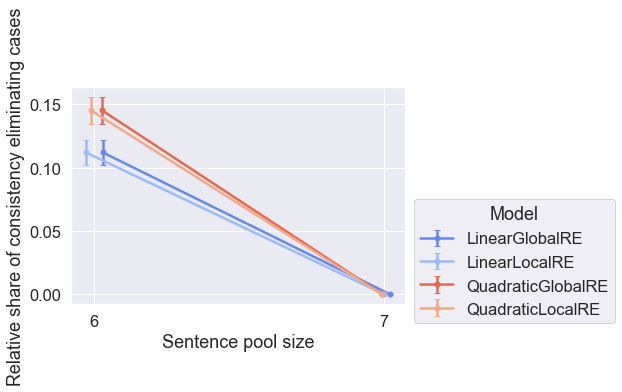

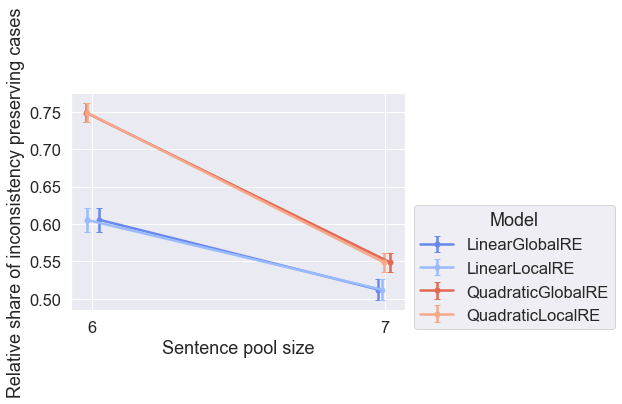

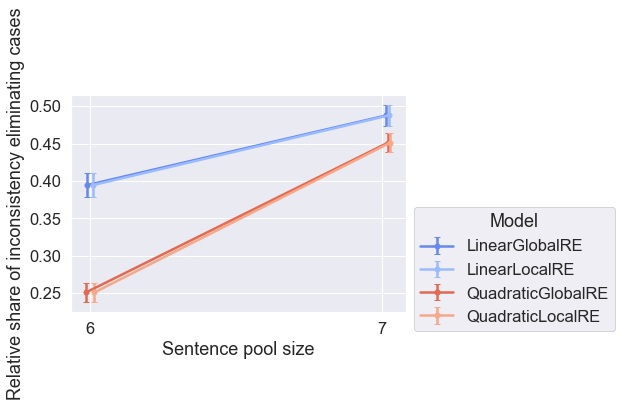

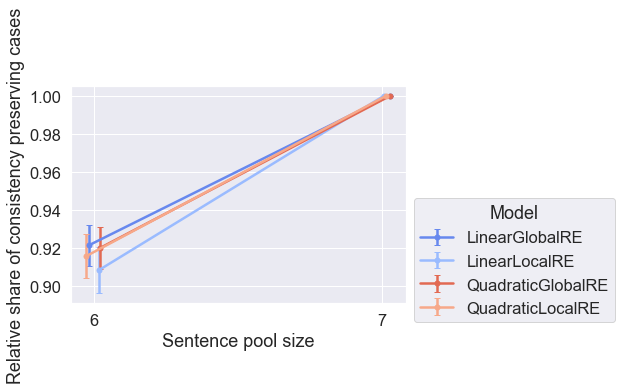

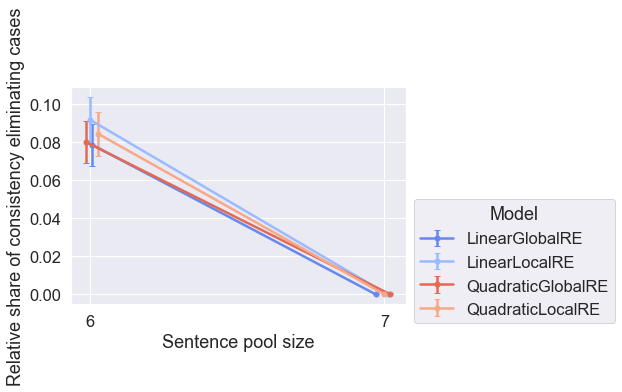

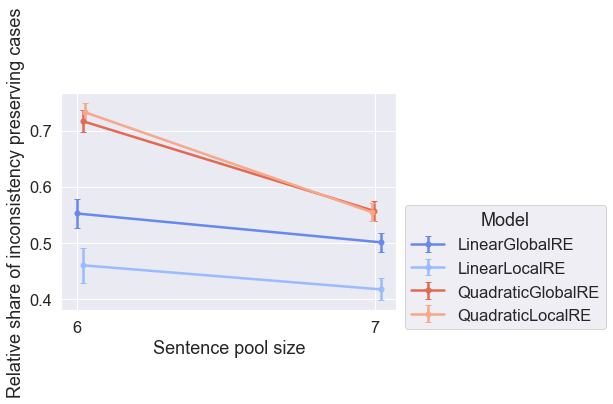

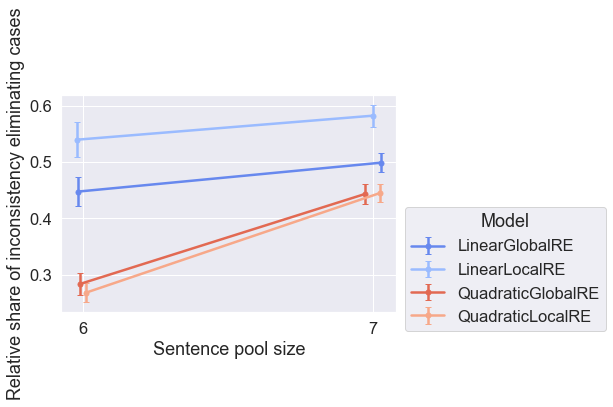

In [68]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    for case_name in ["consistency_preserving",
                      "consistency_eliminating",
                      "inconsistency_preserving",
                      "inconsistency_eliminating", 
                      ]:
        
        if case_name in ["consistency_preserving", "consistency_eliminating"]:
            # consistent init coms
            rdf = df[df["init_coms_dia_consistent"]]
        else:
            rdf = df[~df["init_coms_dia_consistent"]]
        
        result_df = rel_share_of_property(rdf,
                            endpoint_type + "_" + case_name + "_case", 
                            col_rename = None,
                            groupby_cols=grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name',
                                                   'ds',
                                                   'init_coms', 
                                                   'weight_account', 
                                                   'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
        
    
        endpoint = "global optima" if endpoint_type == "go" else "fixed points"
        perspective = "pp" if analyse_branches else "rp"

        file_name = None
        if not on_colab:
            file_name = f"rel_{case_name}_case_{endpoint_type}_by_sp_{perspective}"
            
        xticks = np.sort(df["n_sentence_pool"].unique())

        plot_multiple_error_bars(result_df.reset_index(), 
                                 var_y = f"rel_{endpoint_type}_{case_name}_case", 
                                 ylabel = f"Relative share of {case_name.replace('_', ' ')} cases",
                                 xlabel = "Sentence pool size",
                                 xticks = xticks,
                                 var_std= f"std_{endpoint_type}_{case_name}_case",
                                 file_name=file_name,
                                 output_dir = figures_output_dir)
    
    
    
        plt.show()

### Results grouped by weight configuration

In [44]:
def case_heatmaps_by_weights(data, endpoint_type, case_name, analyse_branches):
     
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdata = data[data["model_name"].isin(go_models)]
    else:
        rdata=data
        
    if case_name in ["consistency_preserving", "consistency_eliminating"]:
        # consistent init coms
        rdata = rdata[rdata["init_coms_dia_consistent"]]
    else:
        # inconsistent init coms
        rdata = rdata[~rdata["init_coms_dia_consistent"]]
         
    
    values_name = endpoint_type + '_' + case_name + '_case' 
        
    
    display_case_name = " ".join(case_name.split("_"))
    
    heat_maps_by_weights(re_data = rdata, 
                     values = values_name, 
                     #title = '{} share of {} cases for {}{}'.format(metric, display_case_name, display_endpoint_type, branches), 
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.2f}',
                     vmin=0, vmax=1,
                     bootstrap = bootstrap,
                     n_resamples = n_resamples)

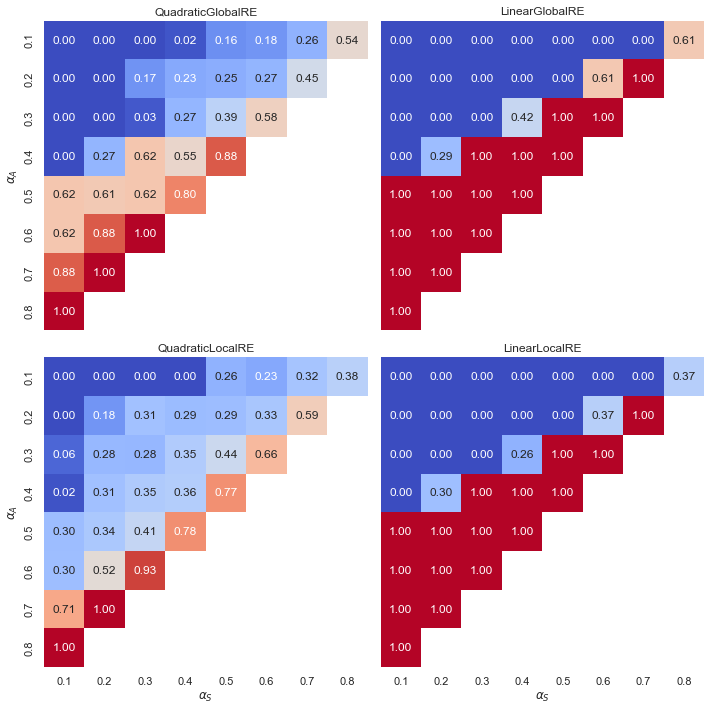

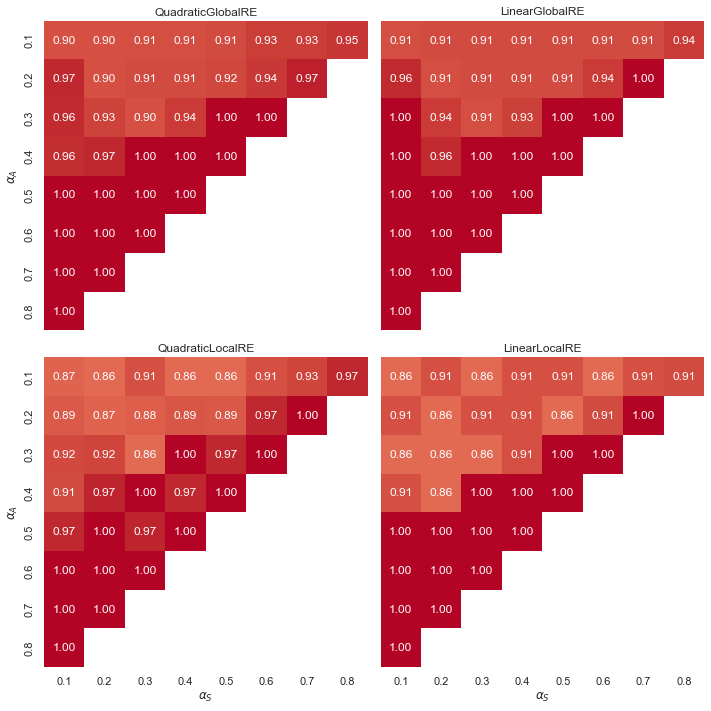

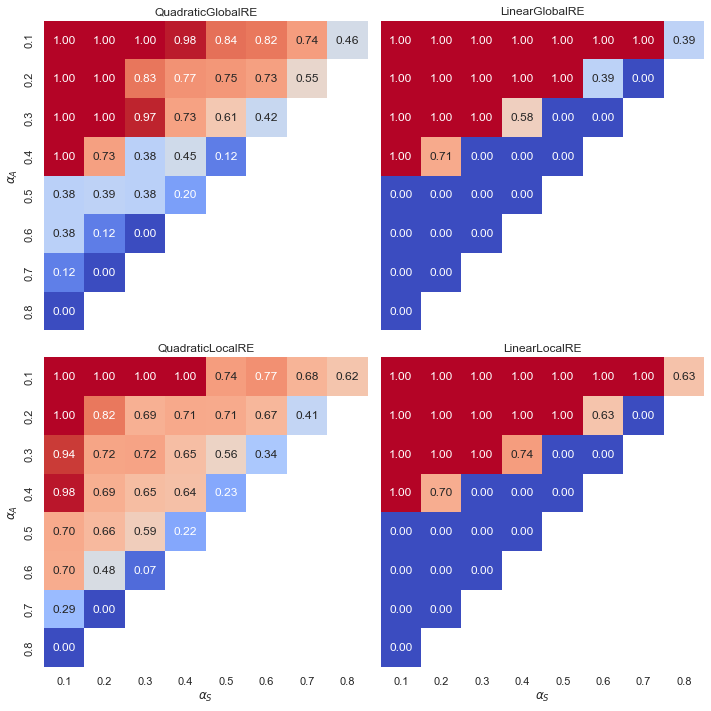

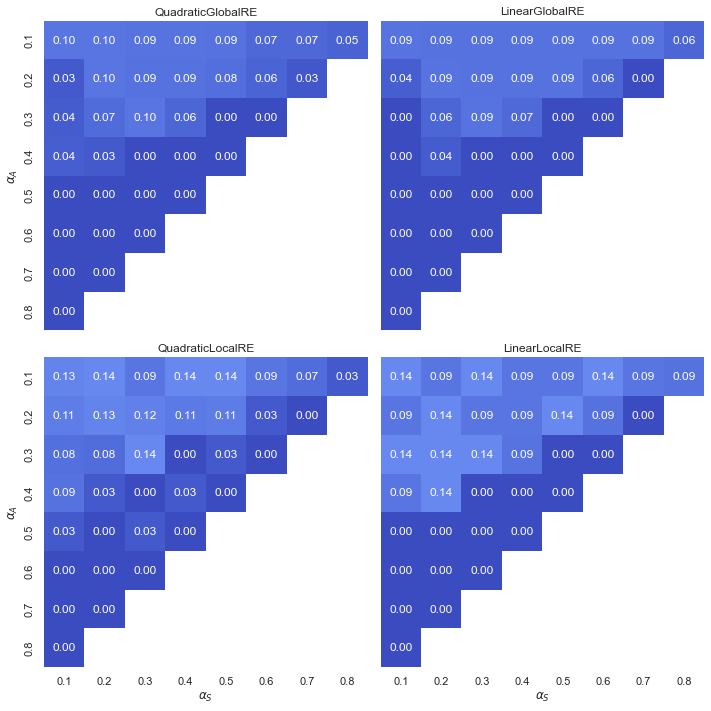

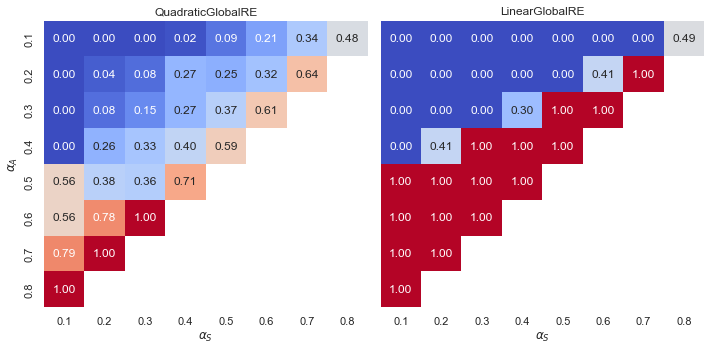

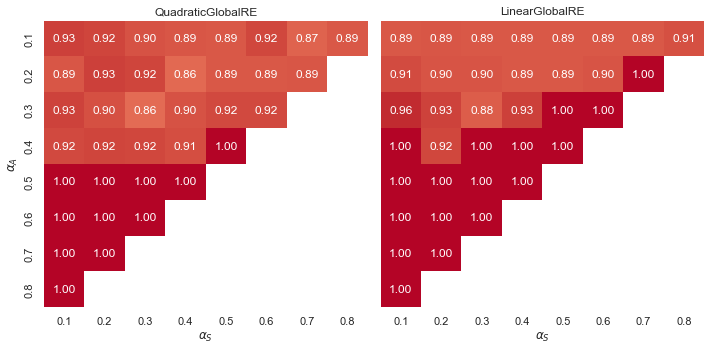

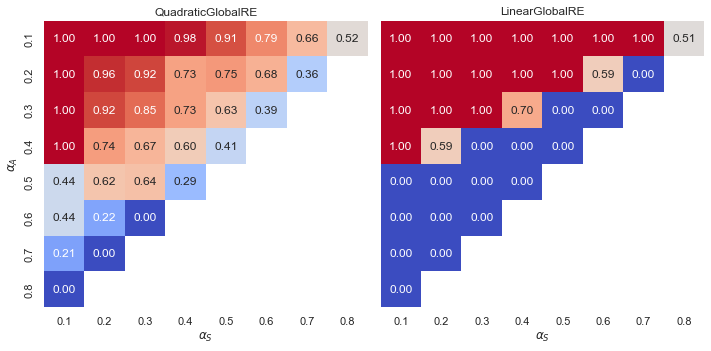

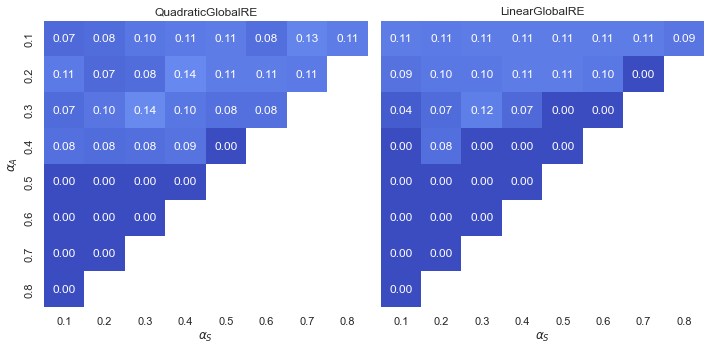

In [45]:
for df, endpoint_type in zip([exploded_fp_data, exploded_go_data], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        case_heatmaps_by_weights(df, endpoint_type, case_name, analyse_branches)
        
        branches = "pp" if analyse_branches else "rp"
        
        if not on_colab:
            plt.savefig(path.join(figures_output_dir, 'hm_{}_{}_cases_{}.png'.format(endpoint_type, case_name, branches)), bbox_inches='tight')
            plt.savefig(path.join(figures_output_dir, 'hm_{}_{}_cases_{}.pdf'.format(endpoint_type, case_name, branches)), bbox_inches='tight')

## Consistency III: Union
Is the union of output theory and output commitments dialectically consistent?

Here, we only count those in-/consistencies, which result from combining dialectically consistent commitments with their theories. In other words, we are interested in those inconsistencies in positions which cannot be explained by commitments being inconsistent on their own (which we already assessed above).

In [46]:
# restrict data to endpoints with consistent commitments

restricted_go_data = exploded_go_data[exploded_go_data["go_coms_consistent"]]
restricted_fp_data = exploded_fp_data[exploded_fp_data["fp_coms_consistent"]]

In [125]:
for df, endpoint_type in zip([restricted_go_data, restricted_fp_data], ["go", "fp"]):  
    
    result_df = rel_share_of_property(df, 
                           "{}_union_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'sum_go_union_consistent': 'Number of global optima with a consistent union',
                   'size_go_union_consistent': 'Number of global optima with consistent commitments',
                   'rel_go_union_consistent': 'Relative share of global optima with a consistent union',
                   'std_go_union_consistent': 'Standard deviation',
                   'sum_fp_union_consistent': 'Number of fixed points with a consistent union',
                   'size_fp_union_consistent': 'Number of fixed points with consistent commitments',
                   'rel_fp_union_consistent': 'Relative share of fixed points with a consistent union',
                   'std_fp_union_consistent': 'Standard deviation',
                  }

    display(result_df.rename(columns=cols_for_tables))
    
    # Exporting relevant cols
    if not on_colab:
        file_name = 'table_consistency_union_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Relative share of global optima with a consistent union,Standard deviation,Number of global optima with a consistent union,Number of global optima with consistent commitments
2,QuadraticGlobalRE,0.931060,0.000336,492856,529359
0,LinearGlobalRE,0.965773,0.000239,522055,540556
3,QuadraticLocalRE,0.931753,0.000353,489618,525490
1,LinearLocalRE,0.965745,0.000249,535532,554525


,Model,Relative share of fixed points with a consistent union,Standard deviation,Number of fixed points with a consistent union,Number of fixed points with consistent commitments
2,QuadraticGlobalRE,0.914998,0.000475,305081,333436
0,LinearGlobalRE,0.960434,0.000429,218022,227000
3,QuadraticLocalRE,0.892535,0.000477,361422,404941
1,LinearLocalRE,0.973280,0.000358,182164,187163


### Results grouped by sentence pool sizes

In [47]:
grouping = ['model_name',
            'n_sentence_pool',
           ]

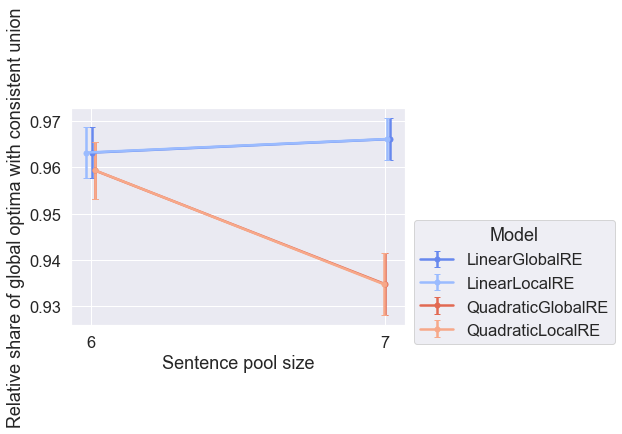

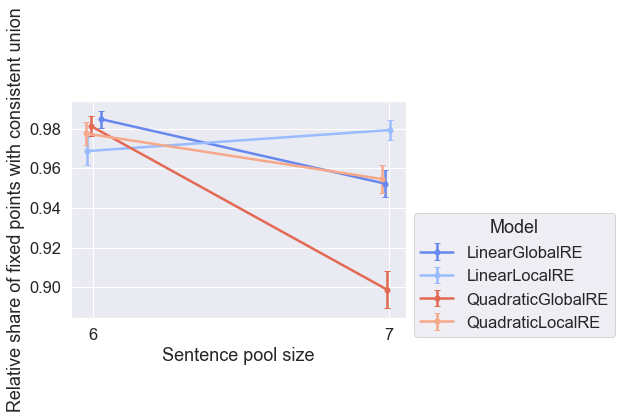

In [69]:
for df, endpoint_type in zip([restricted_go_data, restricted_fp_data], ["go", "fp"]):
    
    
    result_df = rel_share_of_property(df, 
                           "{}_union_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    perspective = "pp" if analyse_branches else "rp"
    
    file_name = None
    if not on_colab:
        file_name = f"rel_consistent_union_{endpoint_type}_by_sp_{perspective}"
        
    xticks = np.sort(df["n_sentence_pool"].unique())
    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_union_consistent", 
                             ylabel = f"Relative share of {endpoint} with consistent union",
                             xlabel = "Sentence pool size",
                             xticks = xticks,
                             var_std=f"std_{endpoint_type}_union_consistent",
                             file_name=file_name,
                             output_dir = figures_output_dir)
      
    plt.show()

### Results grouped by weigh configuration

In [128]:
new_grouping = ["model_name", 
                "weight_account", 
                "weight_systematicity"]

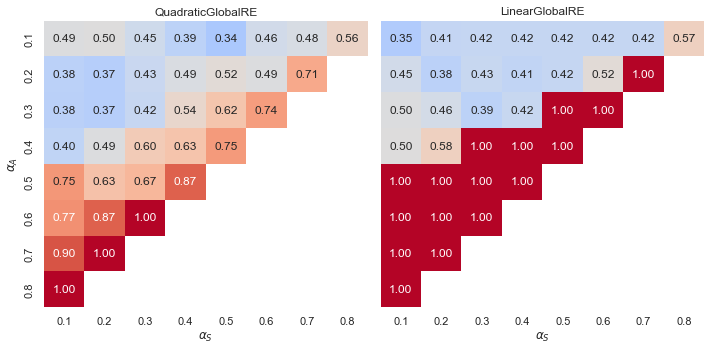

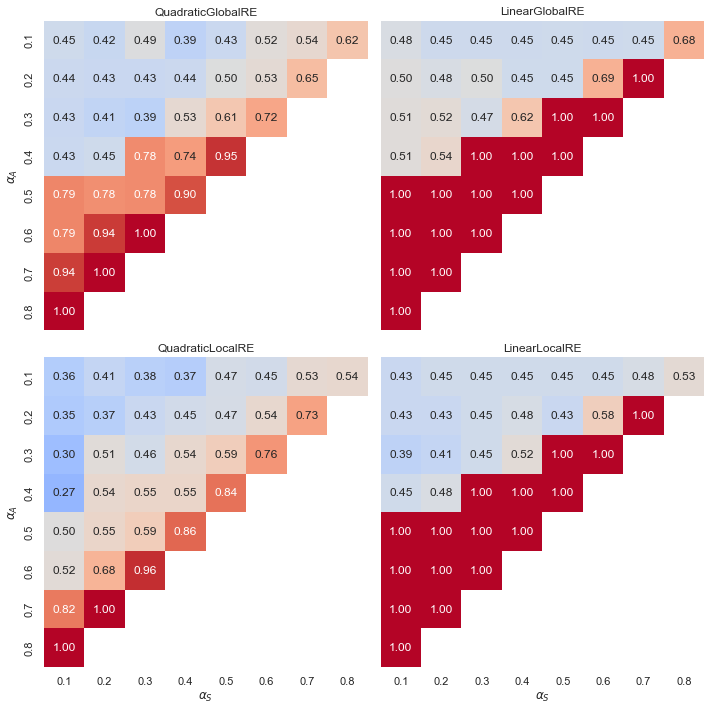

In [50]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):

    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdf = df[df["model_name"].isin(go_models)]
    else:
        rdf=df
    
    heat_maps_by_weights(re_data = rdf, 
                     values = "{}_union_consistent".format(endpoint_type), 
                     #title = 'Relative share of consistent unions among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.2f}',
                     vmin=0,
                     vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    
    branches = "pp" if analyse_branches else "rp" 
        
    if not on_colab:
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_union_{}_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_union_{}_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')
        
    plt.show()